In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc

%matplotlib inline
color = sns.color_palette()

In [2]:
df = pd.read_json('reviews_Cell_Phones_and_Accessories_5.json', lines=True)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400
1,120401325X,"[0, 0]",5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600
2,120401325X,"[0, 0]",5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600
4,120401325X,"[2, 3]",5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600


<b> From the text analysis that we did in "sentiment_analysis_ml" we already know the nature of text, we will now proceed directly with text processing and will build a Deep Learning Model using that<b>

In [4]:
df = df.drop(labels=['asin', 'helpful','reviewTime','reviewerID','reviewerName','summary', 'unixReviewTime'], axis=1)

<b> Let's bucketize the rating into 3 categories, namely: Positive, Neutral and Negative.<br>
    Rating 5 will be marked as Positive<br>
    Rating 3 & 4 will be bucktized together as Neutral<br>
    Rating 2 & 1 will be now be bucktized together as Negative

In [5]:
def create_bucket(data):
    
    if data == 5:
        return "Positive"
    elif data == 4 or data == 3:
        return "Neutral"
    else:
        return "Negative"

In [6]:
df['overall'] = df['overall'].apply(lambda x: create_bucket(x))

#### Loading <a href="http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip">GloVe</a> Word Embeddings

In [7]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [8]:
embedding = load_embed('glove.840B.300d.txt')

<b> Now we should build our vocab keeping the frequency of each word in the vocab

In [9]:
from collections import defaultdict

def build_vocab(sentences):
    fd = defaultdict(int)
    for sentence in tqdm(sentences):
        for word in sentence:
            fd[word]+=1
    return fd

<b> Let's create a function to check how many words in our vocab are actually present in out embedding

In [10]:
def embed_intersection(vocab,embedding):
    temp = {}
    oov = {}
    i = 0
    j = 0
    
    for word in vocab.keys():
        try:
            temp[word] = embedding[word]
            i+=vocab[word]
        except:
            oov[word] = vocab[word]
            j+=vocab[word]
            pass
    
    print(f"Found embeddings for {(len(temp)/len(vocab)*100):.3f}% of vocab")
    print(f"Found embeddings for {(i/(i+j))*100:.3f}% of all text")
    
    sorted_x = sorted(oov.items(), key = lambda x: x[1])[::-1]
    return sorted_x

In [11]:
tqdm.pandas()
sentences = df['reviewText'].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = embed_intersection(vocab,embedding)

100%|██████████| 194439/194439 [00:02<00:00, 83387.39it/s]


Found embeddings for 20.674% of vocab
Found embeddings for 92.221% of all text


<b> Embeddings are available from 20.674% of our vocab, let's check top ten out of vocab words

In [12]:
oov[:10]

[('phone,', 13181),
 ('case,', 11001),
 ("isn't", 7554),
 ("won't", 7193),
 ('However,', 5724),
 ('charger.', 4914),
 ("wasn't", 4715),
 ('well,', 4665),
 ("haven't", 4322),
 ("wouldn't", 4185)]

It may happen that due the presence of puncatuation words might be the same as the one's present in embedding, also beacuse present of capital letters words might be getting out of vocab, let's fix all these issues

In [13]:
df['lower_rev'] = df['reviewText'].apply(lambda x: x.lower())

But making the words in lower case can lead to loss of information as there are words whose embeddings are present in upper case only.

We can fix this:

* word.lower() takes the embedding of word if word.lower() doesn't have an embedding

In [14]:
def fix_case(embedding,vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:
            embedding[word.lower()] = embedding[word]
            count +=1
    print(f'{count} no of words inserted into embedding')

In [15]:
oov = embed_intersection(vocab,embedding)
fix_case(embedding,vocab)
oov = embed_intersection(vocab,embedding)

Found embeddings for 20.674% of vocab
Found embeddings for 92.221% of all text
10061 no of words inserted into embedding
Found embeddings for 20.911% of vocab
Found embeddings for 92.253% of all text


We can see that the punctuations and contractions are causing the mismatch between our vocab and embeddings

In [16]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                       "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not",
                       "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  
                       "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                       "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                       "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                       "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                       "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", 
                       "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": 
                       "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                       "what'll've": "what will have", "what're": "what are",  "what's": "what is", 
                       "what've": "what have", "when's": "when is", "when've": "when have", 
                       "where'd": "where did", "where's": "where is", "where've": "where have", 
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", 
                       "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [17]:
def cont_map(embedding):
    known = []
    for cont in contraction_mapping:
        if cont in embedding:
            known.append(cont)
    return known

In [18]:
cont_map(embedding)

["can't",
 "'cause",
 "didn't",
 "doesn't",
 "don't",
 "I'd",
 "I'll",
 "I'm",
 "I've",
 "i'd",
 "i'll",
 "i'm",
 "i've",
 "it's",
 "ma'am",
 "o'clock",
 "that's",
 "you'll",
 "you're"]

<b> It can be seen that not all contractions are present in the embeddings, we will now be replacing them

In [19]:
def fix_cont(sentence,mapping):
    sentence = str(sentence)
    specials = ["’", "‘", "´", "`"]
    for each in specials:
        sentence = sentence.replace(each,"'")
    sentence = " ".join([mapping[word] if word in mapping else word for word in sentence.split(" ")])
    return sentence

In [20]:
df['fixed_rev'] = df['lower_rev'].apply(lambda x: fix_cont(x,contraction_mapping))

In [21]:
sentences = df['fixed_rev'].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = embed_intersection(vocab,embedding)

100%|██████████| 194439/194439 [00:02<00:00, 81440.50it/s]


Found embeddings for 18.541% of vocab
Found embeddings for 92.753% of all text


In [22]:
oov[:10]

[('phone,', 13345),
 ('case,', 11204),
 ('however,', 8158),
 ('well,', 5626),
 ('charger.', 5035),
 ('great,', 4202),
 ('it!', 3681),
 ('me,', 3677),
 ('on,', 3669),
 ('time,', 3645)]

####  Now it's time to deal with puncuations and special characters

In [23]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [24]:
def fix_punt(sentence,punct):
    
    for p in punct:
        sentence = sentence.replace(p, f' {p} ')
    return sentence

In [25]:
df['fixed_rev'] = df['fixed_rev'].apply(lambda x: fix_punt(x,punct))

In [26]:
sentences = df['fixed_rev'].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = embed_intersection(vocab,embedding)

100%|██████████| 194439/194439 [00:02<00:00, 88667.75it/s]


Found embeddings for 62.501% of vocab
Found embeddings for 99.720% of all text


#### We can see a huge improvement now embeddings are present for 99.72% of all the text in the dataset

In [27]:
oov[:20]

[('bolse', 452),
 ('ismooth', 410),
 ('maxboost', 375),
 ('newtrent', 273),
 ('itorch', 268),
 ('000mah', 263),
 ('caseology', 260),
 ('zerolemon', 256),
 ('icarrier', 225),
 ('otterboxes', 222),
 ('easyacc', 209),
 ('nt90c', 191),
 ('sharkk', 190),
 ('zeetron', 180),
 ('frieq', 173),
 ('jackery', 162),
 ('incredicharge', 136),
 ('gopower', 135),
 ('hx550', 133),
 ('eargels', 131)]

We can see that now most of the out of vocab words are due to use of some slang or due to some spelling mistake.<br>
__Note__:
* We can further increase the intersection between our vocab and Glove by fixing speeling mistake, but we will left this step for now

In [28]:
df = df.drop(labels=['reviewText', 'lower_rev'], axis=1)

Now the embeddings covers almost all of our text data, let move ahead and start building model

In [29]:
def avg_len(data):
    len_str = data['fixed_rev'].apply(lambda x : len(x.split()))
    return np.mean(len_str)

In [30]:
df.head()

,overall,fixed_rev
0,Neutral,they look good and stick good ! i just do not...
1,Positive,these stickers work like the review says they ...
2,Positive,these are awesome and make my phone look so st...
3,Neutral,item arrived in great time and was in perfect ...
4,Positive,"awesome ! stays on , and looks great . can ..."


Average Lenth of reviews given

In [31]:
avg_len(df)

107.9483385534795

In [32]:
vocab_size = len(vocab) + 1
max_len = 108

In [33]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [34]:
def process_data(data):
    
    t = Tokenizer(filters='')
    t.fit_on_texts(data)
    data = t.texts_to_sequences(data)
    data = pad_sequences(data,maxlen = max_len)
    return data, t.word_index,t

In [35]:
X, word_index, tokenizer = process_data(df['fixed_rev'])

In [36]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
df['overall'] = le.fit_transform(df['overall'])

In [37]:
from sklearn.model_selection import train_test_split

y = df['overall'].values

In [38]:
from keras.utils import to_categorical
y_binary = to_categorical(y)

### Ideally we should divide the dataset in three subsets Test, Train & Validation so as to build more robust model but for the sake of exam will be dividing it into train and test set.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y_binary,test_size=0.1,random_state=17)

In [40]:
X_train.shape

(174995, 108)

#### Let's make our embedding matrix

In [41]:
def make_embed_mat(embedding,word_index,vocab_size):
    embds = np.stack(embedding.values())
    emb_mean,emb_std = embds.mean(), embds.std()
    embed_size = embds.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean,emb_std,(vocab_size,embed_size))
    
    for word,i in word_index.items():
        if i>=vocab_size:
            continue
        embedding_vec = embedding.get(word)
        if embedding_vec is not None:
            embedding_matrix[i] = embedding_vec
    return embedding_matrix

In [42]:
embed_matrix = make_embed_mat(embedding,word_index,vocab_size)
del word_index, vocab, sentences
gc.collect()

/home/aadil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


83

In [43]:
embed_matrix.shape

(86536, 300)

In [44]:
from keras.layers import Dense, Embedding, CuDNNGRU, Bidirectional, GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D,concatenate,Input, Dropout
from keras.optimizers import Adam
from keras.models import Model

<b> Building a GRU based deep learning model

In [45]:
def make_model(embedding_matrix, embed_size=300, loss='categorical_crossentropy'):
    
    inp = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size,output_dim=embed_size,weights=[embedding_matrix],trainable=False)(inp)
    x = Bidirectional(CuDNNGRU(128,return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pl = GlobalAveragePooling1D()(x)
    max_pl = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pl,max_pl])
    dense  = Dense(64, activation="relu")(concat)
    dense  = Dropout(rate = 0.7)(dense)
    output = Dense(3, activation="softmax")(dense)
    
    model = Model(inputs=inp, output=output)
    model.compile(loss=loss,optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

In [46]:
model = make_model(embed_matrix)

W0906 17:14:36.279181 139997342480192 deprecation_wrapper.py:119] From /home/aadil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 17:14:36.305133 139997342480192 deprecation_wrapper.py:119] From /home/aadil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 17:14:36.308362 139997342480192 deprecation_wrapper.py:119] From /home/aadil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 17:14:36.348826 139997342480192 deprecation_wrapper.py:119] From /home/aadil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_sessio

In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 108)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 108, 300)     25960800    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 108, 256)     330240      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 108, 128)     123648      bidirectional_1[0][0]            
__________________________________________________________________________________________________
global_ave

In [48]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [49]:
checkpoints = ModelCheckpoint('model.h5',monitor='val_acc',mode='max',save_best_only='True',verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

In [50]:
epochs = 15
batch_size = 128

#### Training the model on Nvidia GTX 1050Ti GPU, locally 

In [51]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=[X_test, y_test], callbacks=[checkpoints, reduce_lr])

W0906 17:14:42.255306 139997342480192 deprecation.py:323] From /home/aadil/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 174995 samples, validate on 19444 samples
Epoch 1/15
174995/174995 [==============================] - 83s 476us/step - loss: 0.8344 - acc: 0.6106 - val_loss: 0.7276 - val_acc: 0.6635

Epoch 00001: val_acc improved from -inf to 0.66350, saving model to model.h5
Epoch 2/15
174995/174995 [==============================] - 81s 464us/step - loss: 0.7228 - acc: 0.6757 - val_loss: 0.6732 - val_acc: 0.6980

Epoch 00002: val_acc improved from 0.66350 to 0.69800, saving model to model.h5
Epoch 3/15
174995/174995 [==============================] - 81s 462us/step - loss: 0.6808 - acc: 0.7014 - val_loss: 0.6334 - val_acc: 0.7224

Epoch 00003: val_acc improved from 0.69800 to 0.72238, saving model to model.h5
Epoch 4/15
174995/174995 [==============================] - 81s 464us/step - loss: 0.6532 - acc: 0.7175 - val_loss: 0.6111 - val_acc: 0.7353

Epoch 00004: val_acc improved from 0.72238 to 0.73534, saving model to model.h5
Epoch 5/15
174995/174995 [==============================] - 83s 

__Note__:
__Scope of improvement__:

* Architecture can be changed instead of using GRU, LSTM can be used it will give better result but will be more computationally expensive to train

* More layers can be added with the combination of some dense layers, it could further boost the performance(Beware of over-fitting)
* Use of <a href="https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf"> Attention Model</a> gives promising results in these kind of usecases.
* BERT and XLnet can be expiremented with which may produce more robust models and can give more promising results.

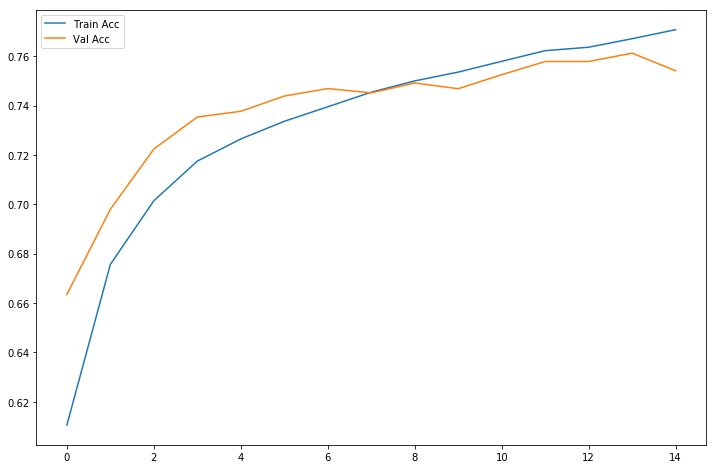

In [52]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.legend(('Train Acc', 'Val Acc'))
plt.show()

Loading the best model

In [53]:
from keras.models import load_model

model = load_model('model.h5')

W0906 17:39:32.284107 139997342480192 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 108)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 108, 300)     25960800    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 108, 256)     330240      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 108, 128)     123648      bidirectional_1[0][0]            
__________________________________________________________________________________________________
global_ave

In [55]:
pred = model.predict(X_test,batch_size=512, verbose=1)

19444/19444 [==============================] - 3s 152us/step


In [57]:
pred[:10]

array([[1.9775175e-01, 3.9597657e-01, 4.0627176e-01],
       [3.4335138e-05, 3.1976182e-02, 9.6798944e-01],
       [1.1641518e-04, 3.6585547e-02, 9.6329802e-01],
       [7.7630496e-03, 2.6969406e-01, 7.2254288e-01],
       [6.2355548e-02, 5.8340317e-01, 3.5424134e-01],
       [1.3594091e-04, 9.0558529e-02, 9.0930551e-01],
       [4.0617511e-03, 1.9149785e-01, 8.0444038e-01],
       [7.6413774e-03, 4.9092937e-01, 5.0142920e-01],
       [3.3241759e-06, 1.2059247e-02, 9.8793739e-01],
       [9.2018499e-06, 4.3849792e-02, 9.5614105e-01]], dtype=float32)

Setting the threshold for predecting the class of a review

In [61]:
from sklearn.metrics import accuracy_score

def tweak_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.75, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = accuracy_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return np.max(scores), thresholds[np.argmax(scores)]

In [62]:
score_val, threshold_val = tweak_threshold(pred, y_test)

print(f"Scored {round(score_val, 4)} for threshold {threshold_val} with treated texts on validation data")

Scored 0.7413 for threshold 0.49 with treated texts on validation data


Generating predictions for all the reviews

In [69]:
pred = tokenizer.texts_to_sequences(df['fixed_rev'])
pred = pad_sequences(pred,maxlen = max_len)

In [71]:
pred_final = model.predict(pred,batch_size=512, verbose=1)

194439/194439 [==============================] - 27s 141us/step


In [72]:
df['pred_sentiment'] = np.argmax(pred_final, axis=1)

In [74]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [75]:
df['pred_sentiment'] = le.inverse_transform(df['pred_sentiment'])

In [77]:
df['overall'] = le.inverse_transform(df['overall'])

In [78]:
df.head(25)

,overall,fixed_rev,pred_sentiment
0,Neutral,they look good and stick good ! i just do not...,Neutral
1,Positive,these stickers work like the review says they ...,Positive
2,Positive,these are awesome and make my phone look so st...,Positive
3,Neutral,item arrived in great time and was in perfect ...,Neutral
4,Positive,"awesome ! stays on , and looks great . can ...",Positive
5,Neutral,these make using the home button easy . my da...,Positive
6,Positive,came just as described . . it does not come ...,Positive
7,Negative,it worked for the first week then it only char...,Negative
8,Positive,"good case , solid build . protects phone all...",Positive
9,Positive,this is a fantastic case . very stylish and p...,Positive


<b> The End.Thanks for reading!! 